## Extracting the Data

> See `imessage.py` for the extraction and cleaning code


In [14]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from imessage import load_data
import matplotlib.pyplot as plt
import re

In [15]:
DB_PATH = "chat.db"
GROUP_ID = "44F37110-57B4-4E4B-8BA9-32DA839F6E92"
START_DATE, END_DATE = "2023-01-28", "2024-03-31"
COLORS = ["#c284ff", "#003466"]

dataset = load_data(DB_PATH, GROUP_ID, START_DATE, END_DATE)

In [30]:
dataset.head(5)

,id,guid,thread_guid,date,text,is_from_me,is_sms,reaction_guid,reaction_type
0,29928,F746728F-61B8-4A67-9446-2F58501F6758,None,2023-01-28 15:04:24,****,1,0,None,0
1,29929,341AD790-DB9A-4FD4-9B80-C9652577212C,None,2023-01-28 15:05:26,****,0,0,None,0
2,30173,CFCAB45F-0713-4225-8F6D-7522B4C24C86,None,2023-02-01 15:51:30,****,1,0,None,0
3,30174,5825EA23-15EA-4C4F-BB7D-0CC0E37F668F,None,2023-02-01 15:51:35,**** **** **** ****?,1,0,None,0
4,30178,E8CC006A-B0CB-4A3B-980D-FA71A6BB1F47,None,2023-02-01 16:30:26,**** ****,0,0,None,0


## Message Analysis

### Total Message Count

This includes all text and attachment (non-text) based messages. Upon further investigation, the ratio remained unaffected when _only_ observing text-based messages, and therefore attachment based messages were included in the analysis. An example of an attachment based message in the dataset would be the unicode character `￼`.


,sender,count
0,Them,83634
1,Me,87133


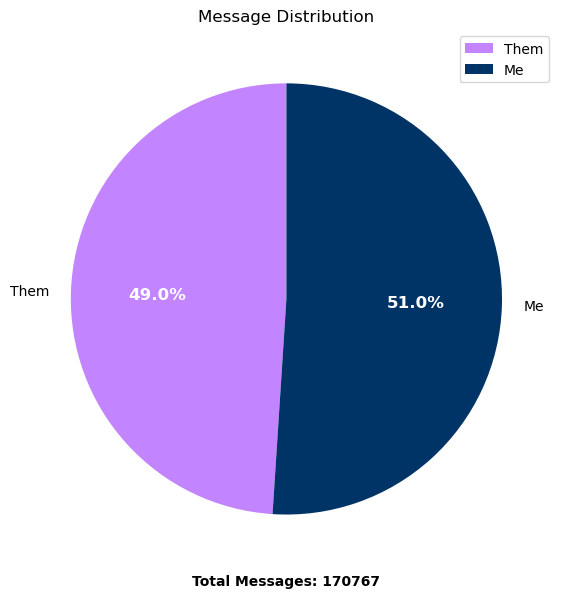

In [17]:
df = dataset.copy()

total_messages = df.shape[0]

# rename is_from_me to sender
message_count = df.groupby("is_from_me").size().reset_index(name="count")
message_count["sender"] = message_count["is_from_me"].apply(
    lambda x: "Me" if x == 1 else "Them"
)

# plot message_count as a pie chart with both percentage and value
ax = message_count.plot.pie(
    y="count",
    labels=["Them", "Me"],
    autopct="%1.1f%%",
    startangle=90,
    figsize=(7, 7),
    colors=COLORS,
)
ax.set_title("Message Distribution")
ax.set_ylabel("")
ax.set_xlabel(f"Total Messages: {total_messages}", fontweight='bold')

for text in ax.texts:
    if "%" in text.get_text():
        text.set_fontsize(12)
        text.set_weight("bold")
        text.set_color("white")

message_count[["sender", "count"]].style.set_caption("Message Count")

### Trend in Message Count

One caveat with this analysis is that often times we might send messages with 1 word, or even 1 emoji. So when we see high message numbers, it might not necessarily mean a lot of text was exchanged. Regardless, its a good metric to see shifts in conversation activity, along with understanding contextual dates and important events that may have influenced the conversation.

Below the plot are the top 5 days with the highest message count, and all days where 0 messages were exchanged. Because the latter only had 14 days total, the longest streak calculation was skipped as its already very clear this conversation was very active.


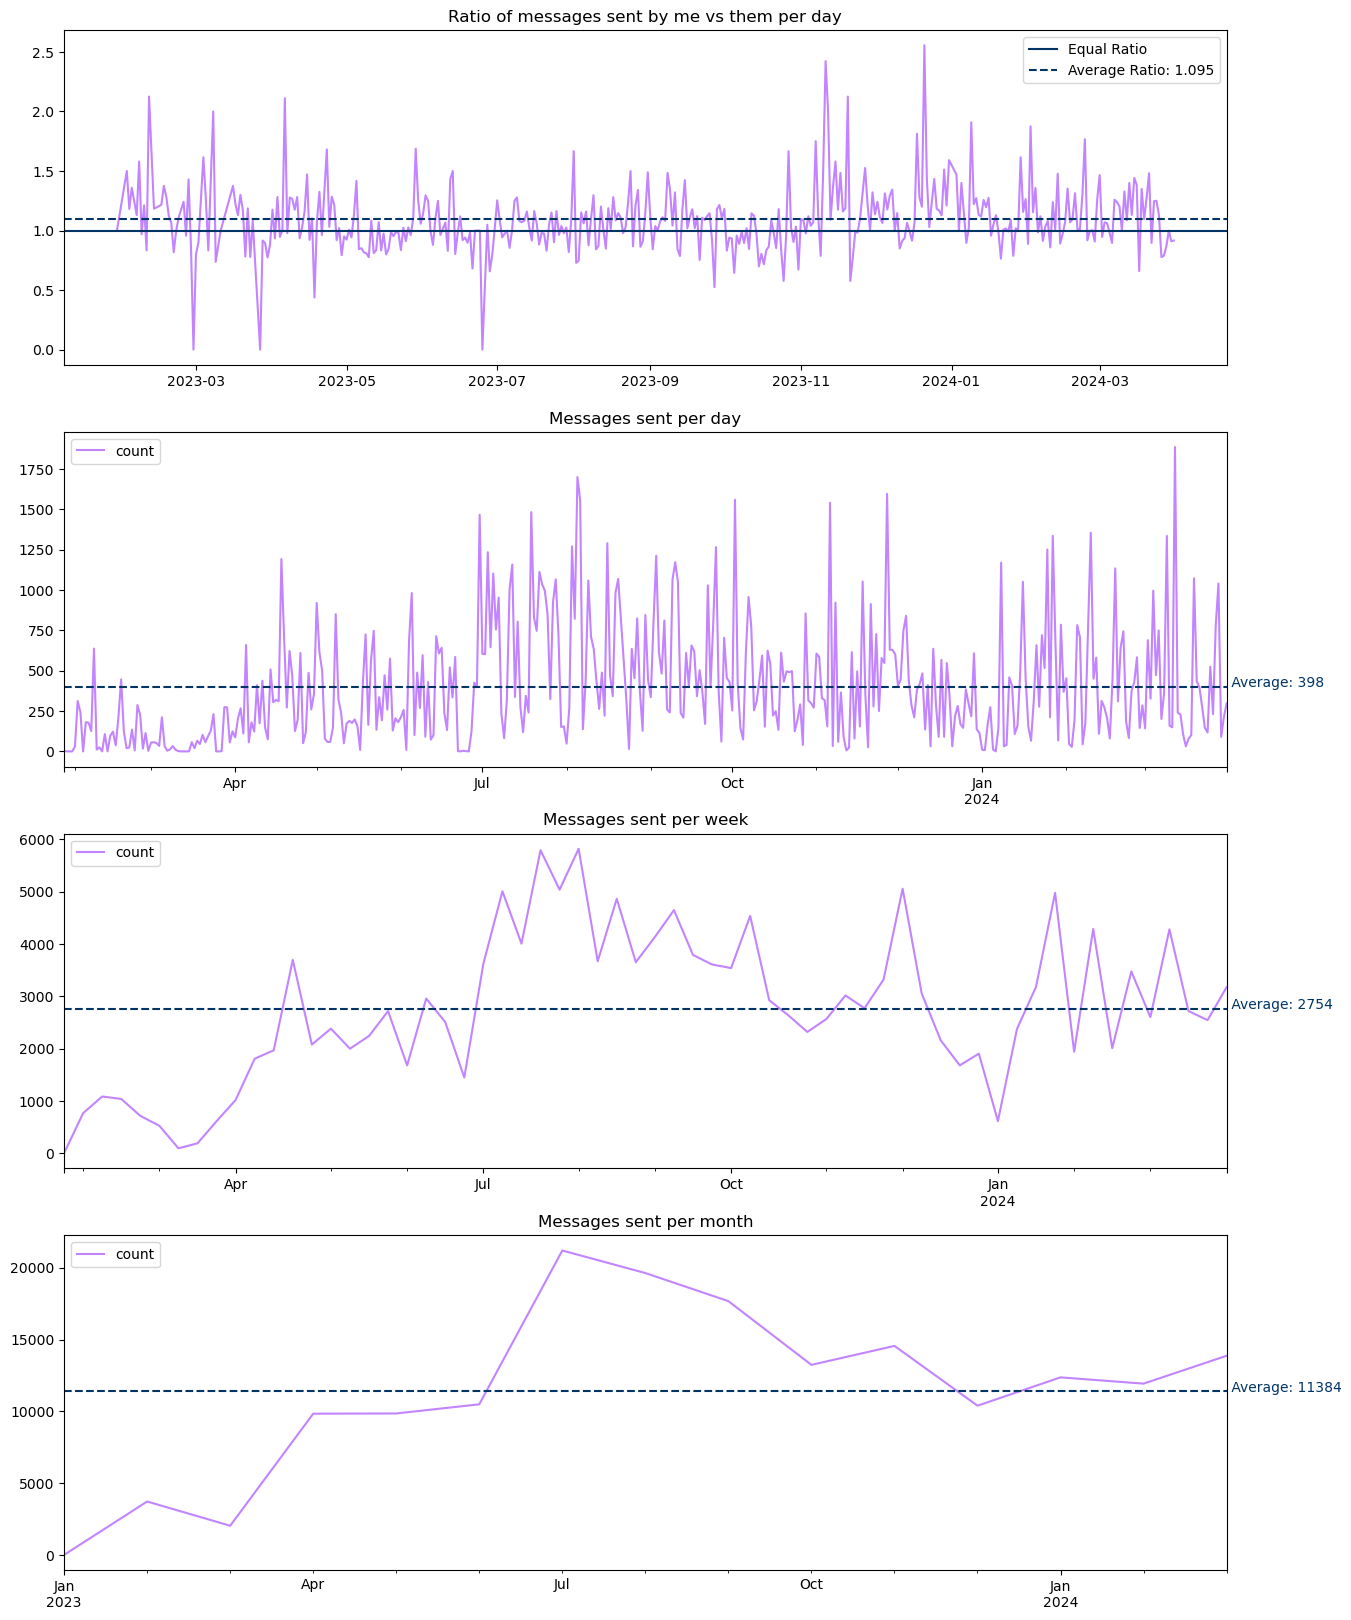

is_from_me,date,0,1,ratio
20,2023-02-23,1.000000,5.000000,5.000000
35,2023-03-10,1.000000,9.000000,9.000000
324,2024-01-01,1.000000,9.000000,9.000000
325,2024-01-02,1.000000,7.000000,7.000000


,date,count
0,2024-03-12,1886
1,2023-08-05,1700
2,2023-11-27,1596
3,2023-10-02,1559
4,2023-08-06,1555


,date,count
0,2023-01-29,0
1,2023-01-30,0
2,2023-01-31,0
3,2023-02-04,0
4,2023-02-11,0
5,2023-02-13,0
6,2023-03-12,0
7,2023-03-13,0
8,2023-03-14,0
9,2023-03-15,0


In [18]:
fig, axs = plt.subplots(4, 1, figsize=(15, 20))


ratio = df[["date", "is_from_me"]].copy()

ratio["date"] = ratio["date"].dt.date
ratio = ratio.groupby(["date", "is_from_me"]).size().unstack().fillna(0).reset_index()

ratio[ratio[0] == 0]
ratio["ratio"] = ratio.apply(lambda x: x[1] / x[0] if x[0] != 0 else 0, axis=1)

# only a few outliers, best to remove it as it skews the graph
outliers = ratio[(ratio["ratio"] > 3)]
outliers.style.set_caption("Hello World")
ratio = ratio[(ratio["ratio"] < 3)]

ratio[["date", "ratio"]].plot.line(x="date", y="ratio", color=COLORS[0], ax=axs[0])

avg_ratio = ratio["ratio"].mean()
avg_line = axs[0].axhline(y=avg_ratio, color=COLORS[1], linestyle="--")
axis_line = axs[0].axhline(y=1.0, color=COLORS[1], linestyle="-")

axs[0].set_xlabel("")
axs[0].legend([axis_line, avg_line], ["Equal Ratio", f"Average Ratio: {avg_ratio:.3f}"])
axs[0].set_title("Ratio of messages sent by me vs them per day")

dfs = []

for i, (freq, label) in enumerate([("D", "day"), ("W", "week"), ("ME", "month")]):
    message_count_by_freq = (
        df.groupby(pd.Grouper(key="date", freq=freq)).size().reset_index(name="count")
    )
    dfs.append(message_count_by_freq)

    message_count_by_freq.plot(x="date", y="count", ax=axs[i + 1], color=COLORS[0])
    axs[i + 1].set_title(f"Messages sent per {label}")
    axs[i + 1].set_ylabel("")
    axs[i + 1].set_xlabel("")
    axs[i + 1].legend(loc="upper left")

    avg_count = message_count_by_freq["count"].mean()
    axs[i + 1].axhline(y=avg_count, color=COLORS[1], linestyle="--")
    axs[i + 1].text(
        message_count_by_freq["date"].iloc[-1],
        avg_count,
        f" Average: {avg_count:.0f}",
        color=COLORS[1],
    )

top_days = (
    dfs[0]
    .sort_values("count", ascending=False)
    .head(5)
    .reset_index()[["date", "count"]]
)
top_days["date"] = top_days["date"].dt.strftime("%Y-%m-%d")

zero_days = dfs[0][dfs[0]["count"] == 0].copy().reset_index()[["date", "count"]]
zero_days["date"] = zero_days["date"].dt.strftime("%Y-%m-%d")

plt.show()

display(outliers.style.set_caption("Outliers in Ratio of Messsages"))
display(top_days.style.set_caption("Top 5 days with most messages"))
display(zero_days.style.set_caption("Days with 0 messages"))

### Ratio of Messages over time

Surprisingly, this ratio of roughly 50/50 in chat messages remained consistent throughout the day, and throughout the week. The only place where there's a significant 'imbalance' is from 03:00 to 06:00, but this makes sense because I wake up around 05:00-06:00, and the other person is usually wakes up a couple hours after, which is represented as the gradual return to 50/50 around 07:00.

Peak times were around the time where both of us would go to sleep, as typically we'd spend the bulk of the morning/afternoon to ourselves working on school or work. I initially assumed that there would have been (awake) hours where the ratio would have been skewed, but when you think about this particular chat, if one person is busy, the other person would save their messages/photos for when the other person is free to respond.


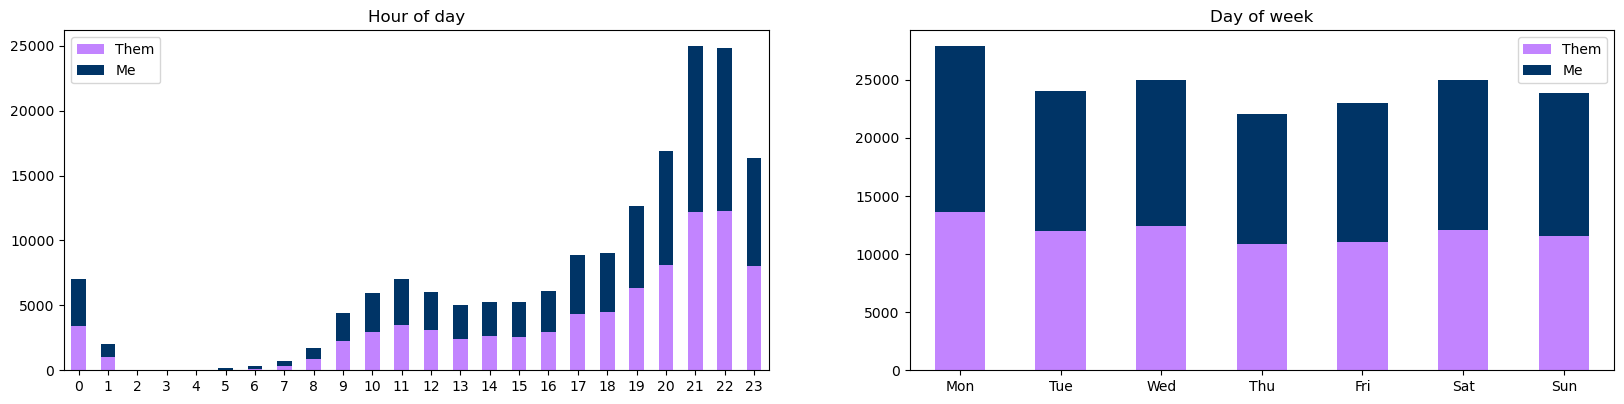

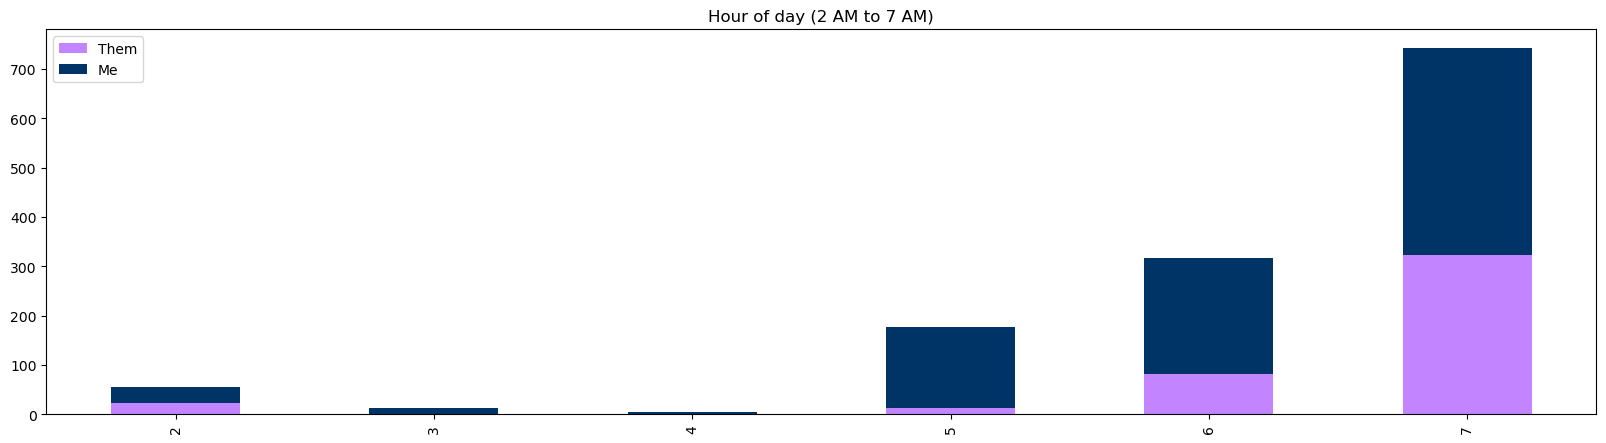

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

df.groupby(df["date"].dt.hour)["is_from_me"].value_counts().unstack().plot(
    kind="bar", stacked=True, title="Hour of day", xlabel="", ax=axs[0], color=COLORS
)

day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df.groupby(df["date"].dt.dayofweek)["is_from_me"].value_counts().unstack().plot(
    kind="bar", stacked=True, title="Day of week", xlabel="", ax=axs[1], color=COLORS
)

axs[0].legend(["Them", "Me"])
axs[1].legend(["Them", "Me"])
axs[1].set_xticklabels(day_labels)

fig.autofmt_xdate(rotation=0, ha="center")

ax = (
    df[(df["date"].dt.hour > 1) & (df["date"].dt.hour < 8)]
    .groupby(df["date"].dt.hour)["is_from_me"]
    .value_counts()
    .unstack()
    .plot(
        kind="bar",
        stacked=True,
        title="Hour of day (2 AM to 7 AM)",
        xlabel="",
        figsize=(20, 5),
        color=COLORS,
    )
)

ax.legend(["Them", "Me"])

plt.show()

### Longest Thread of Messages

This doesn't mean the longest conversation at all, but I figured it was worth seeing how long both us go before the reply chain gets broken. Through the log plot, we see that the length of the the thread is exponential. Neither person has no real motivation to keep the chain going, unless there's two reply threads happening simultaneously. The text content of the conversations are omitted in these findings for the sake of privacy, but upon inspection of the specific threads, I saw a mixture of both serious and friendly conversations, the longest thread happened to be about watches!


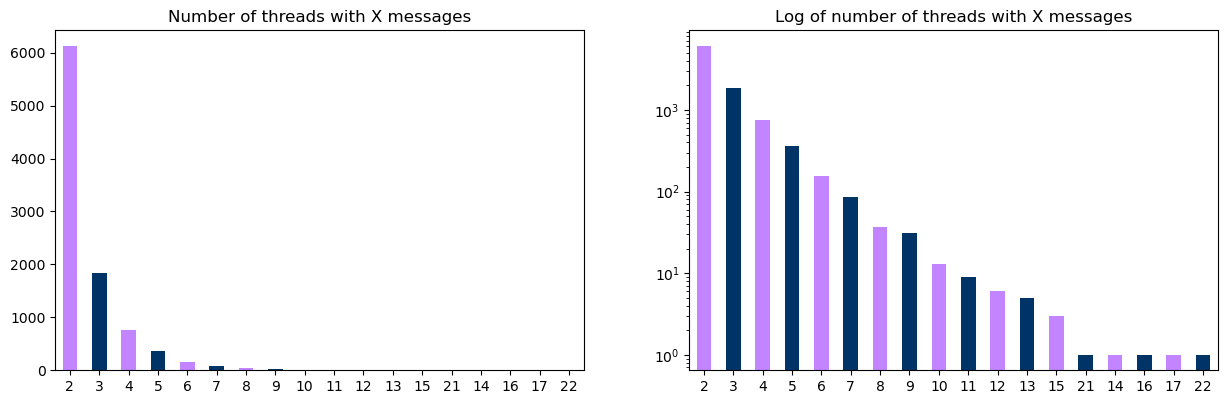

In [20]:
threads = (
    df[~df["thread_guid"].isna()]
    .groupby("thread_guid")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="count")
)
threads["count"] = threads["count"] + 1

# account for the initial message

thread_counts = threads["count"].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

thread_counts.plot(
    kind="bar",
    title="Number of threads with X messages",
    xlabel="",
    color=COLORS,
    ax=ax[0],
)
thread_counts.plot(
    kind="bar",
    title="Log of number of threads with X messages",
    xlabel="",
    color=COLORS,
    ax=ax[1],
    logy=True,
)

fig.autofmt_xdate(rotation=0, ha="center")
plt.show()

### Single-character/Emoji messages

It's a safe assumption that any messages with a text that contains the `￼` symbol is an attachment such as a photo, video, or sticker. Very interesting to see that the ratio is very skewed away from me, which I didn't expect. Due to font rendering on WSL2 I had to use text substitution for the emoji labels, but below the plot is the raw value counts. This is a good preliminary analysis before we do a more thorough job to see how much more skewed the ratio gets when we factor emojis inside sentences. We can stick with the same top 10 as its more likely that we use the same set of emojis inside sentences versus on its own.

Emojis such as 💅 are skewed in this analysis because of the possibility to send skin tone specific versions, this will be covered in the deeper analysis later on.

The comparison between emoji-only messages to full text messages here is skipped because its very obvious to see that emoji-only messages only are a sliver compared to text based, and isn't worth digging into further.   

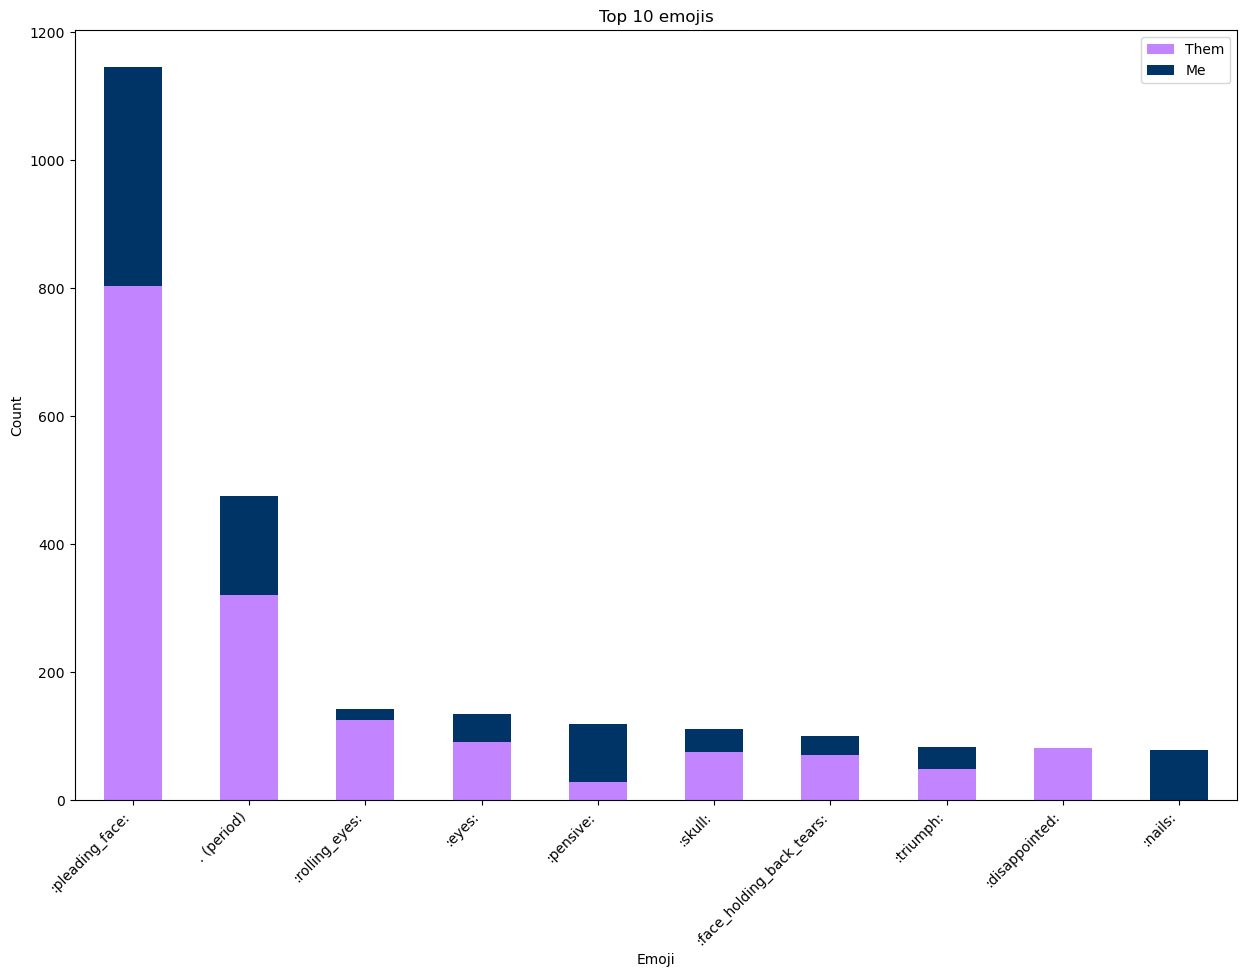

is_from_me,0,1,total
text,,,
🥺,804.000000,342.000000,1146.000000
.,321.000000,155.000000,476.000000
🙄,126.000000,16.000000,142.000000
👀,91.000000,44.000000,135.000000
😔,28.000000,91.000000,119.000000
💀,76.000000,36.000000,112.000000
🥹,71.000000,30.000000,101.000000
😤,49.000000,34.000000,83.000000
😞,81.000000,0.000000,81.000000


In [21]:
df1 = df.drop(df[df["text"].str.contains("￼")].index)

# fmt: off
emoji_text = [":pleading_face:", ". (period)", ":rolling_eyes:", ":eyes:", ":pensive:", ":skull:", ":face_holding_back_tears:", ":triumph:", ":disappointed:", ":nails:"]
# fmt: on

top_10 = (
    df1[
        df1["text"].isin(
            df1[df1["text"].str.len() == 1]["text"].value_counts().head(10).index.values
        )
    ]
    .groupby(df1["text"])["is_from_me"]
    .value_counts()
    .unstack()
    .fillna(0)
)
top_10["total"] = top_10[0] + top_10[1]
top_10.sort_values("total", ascending=False, inplace=True)

ax = top_10.plot(
    kind="bar", y=[0, 1], stacked=True, title="Top 10 emojis", color=COLORS, figsize=(15, 10)
)

ax.set_xticklabels(emoji_text, rotation=45, ha='right')
ax.set_xlabel("Emoji")
ax.set_ylabel("Count")
ax.legend(["Them", "Me"])

plt.show()

top_10.style.set_caption("Top 10 emoji-only messages")

## Word Count 

### Count in Messages - Total and Average

I really thought the word count ratio would be different, but really its very similar, albeit not as close as message count. Very similar with average word count, up to 0.1 difference. This deserves more investigation with average count per time, because I think that's where the real difference will be.

,count,average_count
is_from_me,,
0,470375,5.624208
1,500453,5.743553


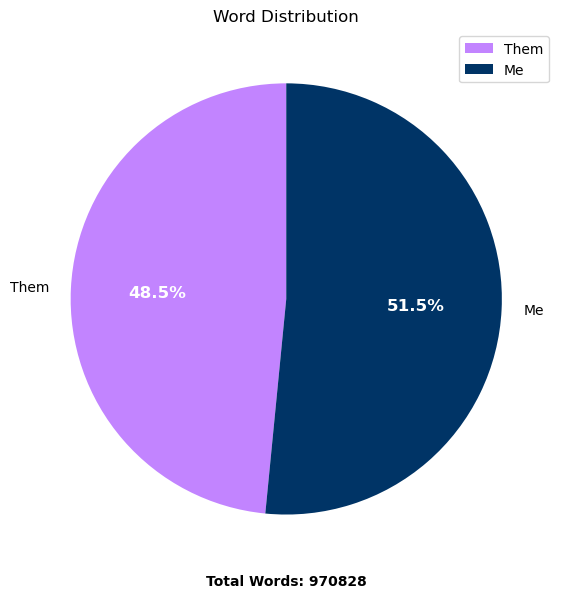

In [22]:
df = dataset.copy()

words = df[['date', 'text', 'is_from_me']].copy()
words['count'] = words["text"].apply(lambda x: len(x.split(" ")))

total_words = len((' '.join(df['text'].values)).split(' '))
per_person = words[['is_from_me', 'count']].groupby('is_from_me').sum()

ax = per_person.plot.pie(
    y='count',
    labels=['Them', 'Me'],
    autopct='%1.1f%%',
    startangle=90,
    figsize=(7, 7),
    colors=COLORS
)

ax.set_title("Word Distribution")
ax.set_ylabel("")
ax.set_xlabel(f"Total Words: {total_words}", fontweight='bold')

for text in ax.texts:
    if "%" in text.get_text():
        text.set_fontsize(12)
        text.set_weight("bold")
        text.set_color("white")

# average words per message per person
per_person['average_count'] = per_person['count'] / message_count['count']

per_person.style.set_caption("Words sent per person + Average words per message")

### Average count per time

This really is just another validation that the word count ratio has stayed similar throughout the dataset, and with contextual understanding of the conversation timeline, it shows from the start, there wasn't this 'dry' or 'one-sided' period where one person was more talkative than the other.

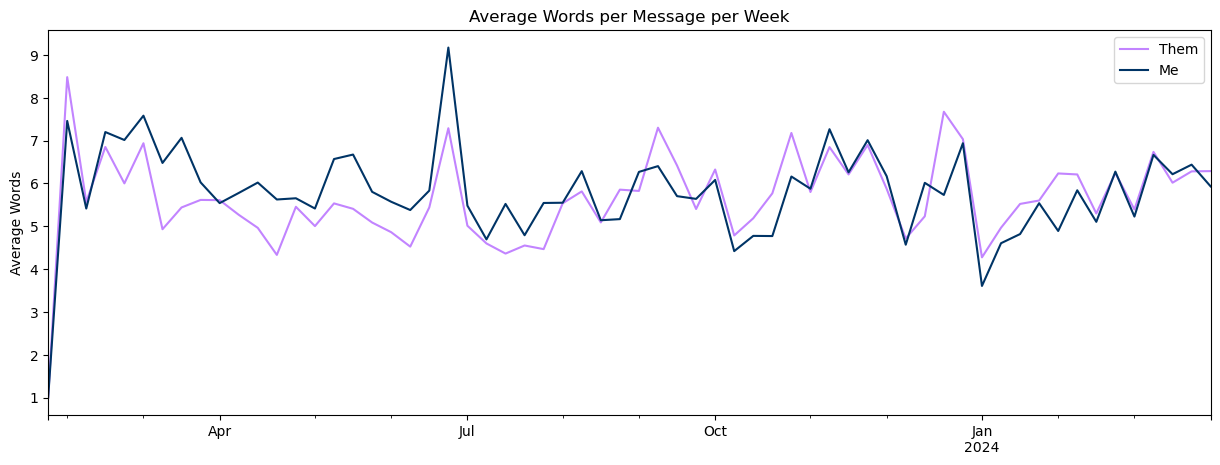

In [23]:
# Average words per message per day over time
avgs = pd.concat(
    [
        words[words["is_from_me"] == 0]
        .groupby(pd.Grouper(key="date", freq="W"))["count"]
        .mean()
        .fillna(0),
        words[words["is_from_me"] == 1]
        .groupby(pd.Grouper(key="date", freq="W"))["count"]
        .mean()
        .fillna(0),
    ],
    axis=1,
    keys=["Them", "Me"],
)

# plot average words per message per day over time
fig, ax = plt.subplots(figsize=(15, 5))
avgs.plot(ax=ax, color=COLORS)
ax.set_title("Average Words per Message per Week")
ax.set_ylabel("Average Words")
ax.set_xlabel("")
ax.legend(["Them", "Me"])

plt.show()

### Dictionary Analysis

The output of this section of the analysis will be redacted for privacy. Throughout the conversation, there are words and phrases that are repeatedly used, such as nicknames and jokes. I'm curious to see who says what more.

In [26]:
patterns_df = df[["text", "is_from_me"]].copy()

patterns = [
    ("WORD1", re.compile("REGEX_FOR_WORD_1")),
    ("WORD2", re.compile("REGEX_FOR_WORD_2")),
    ("WORD3", re.compile("REGEX_FOR_WORD_3")),
    ("WORD4", re.compile("REGEX_FOR_WORD_4")),
    ("WORD5", re.compile("REGEX_FOR_WORD_5")),
    ("WORD6", re.compile("REGEX_FOR_WORD_6")),
    ("WORD7", re.compile("REGEX_FOR_WORD_7")),
]

for i, (label, pattern) in enumerate(patterns):
    patterns_df[label] = patterns_df["text"].str.count(pattern)

patterns_df.drop(columns=["text"]).groupby("is_from_me").sum().style.set_caption(
    "Common phrase counts used in messages"
)

,WORD1,WORD2,WORD3,WORD4,WORD5,WORD6,WORD7
is_from_me,,,,,,,
0,806,655,288,90,880,81,10
1,869,792,2668,81,662,92,2


### Emoji Analysis

This analysis shows that the single-message emoji ratio is not the be-all-end-all, as for example the '💀' emoji here has a closer ratio versus in the single emoji messages. Context on the participants matters as well because iMessage will reduce the size of the emoji after 4 emojis in a row, so I have a tendancy to spam 3 emojis at a time. 

In [25]:
emoji_df = df[['text', 'is_from_me']].copy()
emojis = ['🥺', '🙈', '👀', '🥹', '💀', '🤗', '😘', '💨', '💅', '❤️', '💜', '😩']

for emoji in emojis:
    emoji_df[emoji] = emoji_df['text'].str.count(emoji)

emoji_df.drop(columns=["text"]).groupby("is_from_me").sum().style.set_caption(
    "Emoji counts used in messages"
)

,🥺,🙈,👀,🥹,💀,🤗,😘,💨,💅,❤️,💜,😩
is_from_me,,,,,,,,,,,,
0,3512,97,268,261,240,27,1317,5,172,7,375,62
1,1497,111,144,370,245,128,1686,78,148,379,178,88


## Conclusion

Honestly there's nothing too surprising here, it's just a light analysis of a text conversation. It was interesting to see the trends in message count and how the ratio is very balanced. The coolest part was figuring out how the `chat.db` file works, and how to extract the data. 

### Extensions

**Sentiment analysis on the text**: It would be interesting to bucket periods of conversations into sentiments, and see how these change over time, well knowing the life events that happened during the time period, and seeing if there is a correlation in change. The argument against this is really that the conversation is between two people, and the sentiment is really just a reflection of the mood of the conversation, and not necessarily the mood of the participants. For example, I could be having a bad day, but the conversation is light and fun, so the sentiment would be positive.

The biggest lesson here is that, context matters.

**Training an LLM on the conversation**: This is a bit creepy LOL

**Deeper dive on `chat.db`**: It would be nice to have more robust documentation on how this database is structured. The interactions I found on the internet were very helpful, but I had to piece together a lot of information to get the data I needed. The database contains references to attachments and images, and this analysis skipped through that, a great extension would be to extract that attachment data and analyze it.

<center>Made with 💖 from 🍁</center>